# A2.5 Multilayer Neural Networks for Nonlinear Regression


Austin Youngren

## Summary

In this assignment you will 
* make some modifications to the supplied neural network implementation, 
* define a function that partitions data into training, validation and test sets,
* apply it to a data set, 
* define a function that runs experiments with a variety of parameter values, 
* describe your observations of these results.

## Optimizers

First, we need a class that includes our optimization algorithms, `sgd` and `adam`.  The following code cell implements `sgd`.  You must complete the implementation of `adam`, following its implementation in the lecture notes.

Notice that `all_weights` is updated in place by these optimization algorithms.  The new values of `all_weights` are not returned from these functions, because the code that calls these functions allocates the memory for `all_weights` and keeps the reference to it so has direct access to the new values.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        # The following initializations are only used by adam.
        # Only initializing mt, vt, beta1t and beta2t here allows multiple calls to adam to handle training
        # with multiple subsets (batches) of training data.
        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1  # was self.beta1
        self.beta2t = 1  # was self.beta2

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if (epoch + 1) % max(1, epochs_per_print) == 0:
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Finish Adam implementation here by updating
            #   self.mt
            #   self.vt
            #   self.beta1t
            #   self.beta2t
            # and updating values of self.all_weights
            
            self.mt = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt = self.beta2 * self.vt + (1 - self.beta2) * np.square(grad)
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2

            mhat = self.mt / (1 - self.beta1t)
            vhat = self.vt / (1 - self.beta2t)

            self.all_weights -= alpha * mhat / (np.sqrt(vhat) + epsilon)

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if (epoch + 1) % max(1, epochs_per_print) == 0:
                print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

Test `Optimizers` using the function `test_optimizers`.  You should get the same results shown below.

In [3]:
def test_optimizers():

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin):
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin], n_epochs=100, learning_rate=0.1)
    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin], n_epochs=100, learning_rate=0.1)
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')

In [4]:
test_optimizers()

sgd: Epoch 10 Error=0.45036
sgd: Epoch 20 Error=0.00519
sgd: Epoch 30 Error=0.00006
sgd: Epoch 40 Error=0.00000
sgd: Epoch 50 Error=0.00000
sgd: Epoch 60 Error=0.00000
sgd: Epoch 70 Error=0.00000
sgd: Epoch 80 Error=0.00000
sgd: Epoch 90 Error=0.00000
sgd: Epoch 100 Error=0.00000
sgd: Minimum of parabola is at 5. Value found is [5.]
Adam: Epoch 10 Error=16.85565
Adam: Epoch 20 Error=9.93336
Adam: Epoch 30 Error=5.21627
Adam: Epoch 40 Error=2.37740
Adam: Epoch 50 Error=0.90515
Adam: Epoch 60 Error=0.26972
Adam: Epoch 70 Error=0.05453
Adam: Epoch 80 Error=0.00453
Adam: Epoch 90 Error=0.00016
Adam: Epoch 100 Error=0.00147
adam: Minimum of parabola is at 5. Value found is [5.03900403]


## NeuralNetwork class

Now we can implement the `NeuralNetwork` class that calls the above `Optimizers` functions to update the weights.

You must first complete the `use` function.  You can make use of the `forward_pass` function.

In [5]:
class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs})'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        if self.trained:
            return self.__repr__() + f' trained for {self.total_epochs} epochs, final training error {self.error_trace[-1]}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd'):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units.
        error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

   
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized. Return the unstandardized prediction'''
        Xs = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(Xs)
        Y = Ys[-1] * self.Tstds + self.Tmeans
        return Y

Then test it with the `test_neuralnetwork` function.  Your results should be the same as those shown, because the pseudo-random number generator used to initialize the weights is set to start with the same seed.

In [6]:
np.random.seed(42)
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.02509198,  0.09014286],
       [ 0.04639879,  0.0197317 ]])

In [7]:
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.06879627, -0.0688011 ],
       [-0.08838328,  0.07323523]])

In [8]:
np.random.seed(42)
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.02509198,  0.09014286],
       [ 0.04639879,  0.0197317 ]])

In [9]:
def test_neuralnetwork():
    
    np.random.seed(42)
    
    X = np.arange(100).reshape((-1, 1))
    T = np.sin(X * 0.04)
    print('X: ', X.shape)
    n_hiddens = [10, 10]
    n_epochs = 2000
    learning_rate = 0.01
    
    nnetsgd = NeuralNetwork(1, n_hiddens, 1)
    nnetsgd.train(X, T, n_epochs, learning_rate, method='sgd')

    print()  # skip a line
    
    nnetadam = NeuralNetwork(1, n_hiddens, 1)
    nnetadam.train(X, T, n_epochs, learning_rate, method='adam')

    Ysgd = nnetsgd.use(X)
    Yadam = nnetadam.use(X)

    plt.figure(figsize=(15,10))
    plt.subplot(1, 3, 1)
    plt.plot(nnetsgd.error_trace, label='SGD')
    plt.plot(nnetadam.error_trace, label='Adam')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(T, Ysgd, 'o', label='SGD')
    plt.plot(T, Yadam, 'o', label='Adam')
    a = min(np.min(T), np.min(Ysgd))
    b = max(np.max(T), np.max(Ysgd))
    plt.plot([a, b], [a, b], 'k-', lw=3, alpha=0.5, label='45 degree')
    plt.xlabel('Target')
    plt.ylabel('Predicted')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(Ysgd, 'o-', label='SGD')
    plt.plot(Yadam, 'o-', label='Adam')
    plt.plot(T, label='Target')
    plt.xlabel('Sample')
    plt.ylabel('Target or Predicted')
    plt.legend()

    plt.tight_layout()

X:  (100, 1)
sgd: Epoch 200 Error=0.49330
sgd: Epoch 400 Error=0.46833
sgd: Epoch 600 Error=0.44525
sgd: Epoch 800 Error=0.42264
sgd: Epoch 1000 Error=0.39428
sgd: Epoch 1200 Error=0.35526
sgd: Epoch 1400 Error=0.30300
sgd: Epoch 1600 Error=0.24079
sgd: Epoch 1800 Error=0.18020
sgd: Epoch 2000 Error=0.13423

Adam: Epoch 200 Error=0.11620
Adam: Epoch 400 Error=0.00795
Adam: Epoch 600 Error=0.00362
Adam: Epoch 800 Error=0.00268
Adam: Epoch 1000 Error=0.00236
Adam: Epoch 1200 Error=0.00213
Adam: Epoch 1400 Error=0.00200
Adam: Epoch 1600 Error=0.00183
Adam: Epoch 1800 Error=0.01152
Adam: Epoch 2000 Error=0.00162


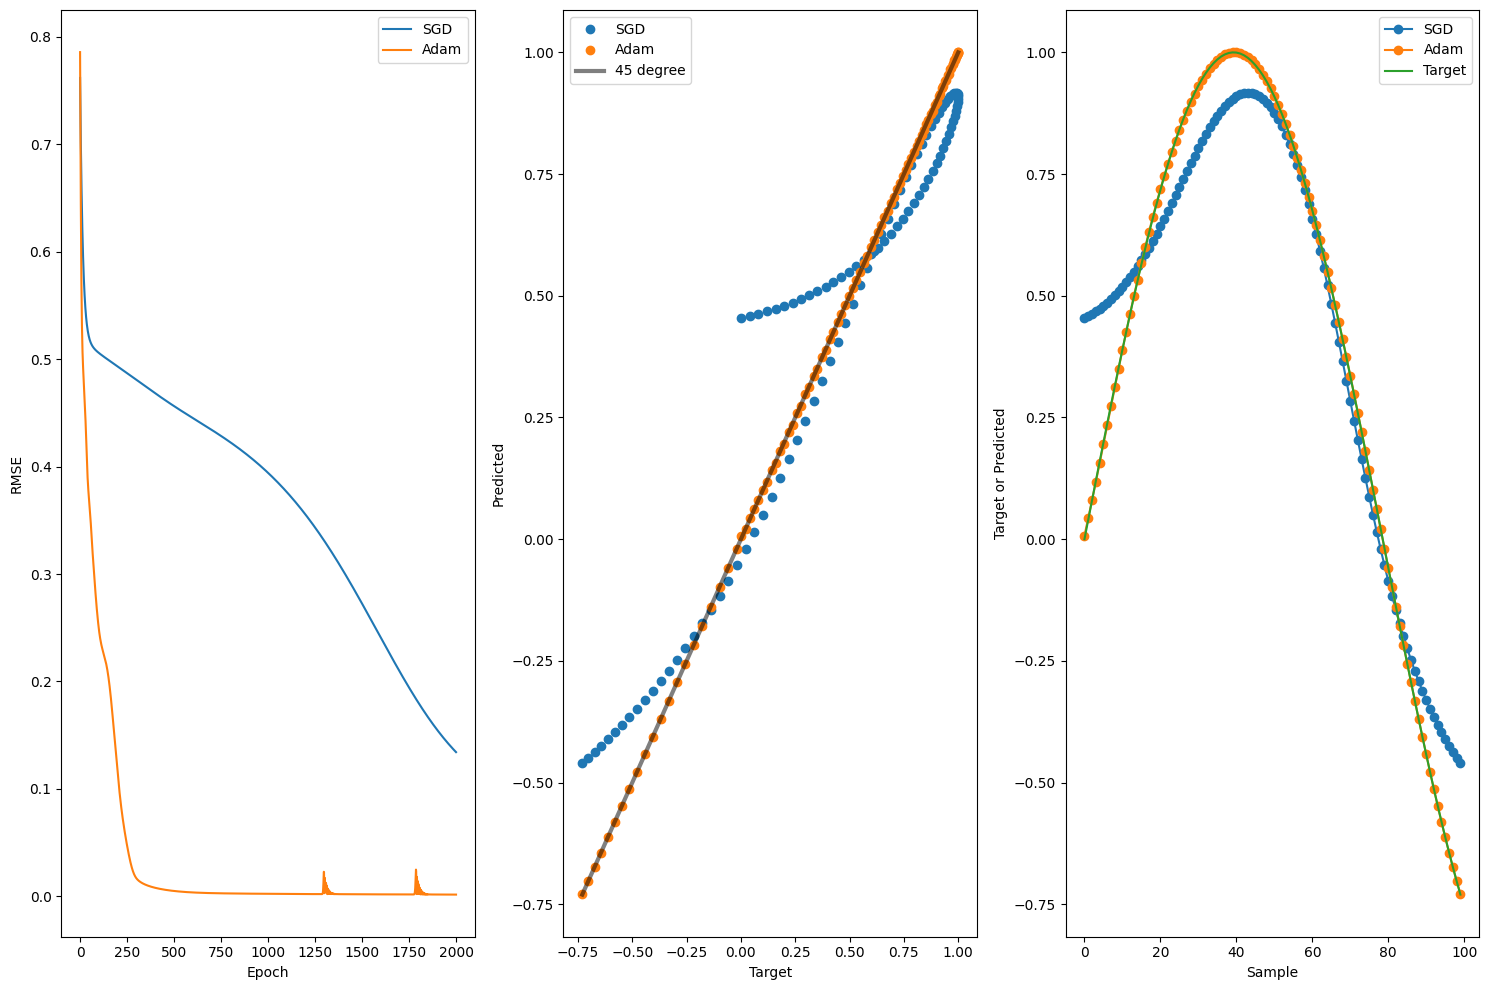

In [10]:
test_neuralnetwork()

## ReLU Activation Function

Cut and paste your `NeuralNetwork` class cell here.  Then modify it to allow the use of the ReLU activiation function, in addition to the `tanh` activation function that `NeuralNetwork` currently uses.  

Do this by
* Add the argument `activation_function` to the `NeuralNetwork` constructor that can be given values of `tanh` or `relu`, with `tanh` being its default value.
* Define two new class functions, `relu(s)` that accepts a matrix of weighted sums and returns the ReLU values, and `grad_relu(s)` that returns the gradient of `relu(s)` with respect to each value in `s`.
* Add `if` statements to `forward_pass` and `gradient_f` to selectively use the `tanh` or `relu` activation function. This is easy if you assign a new class variable in the `NeuralNetwork` constructor that has the value of the argument `activation_function`.

In [11]:
class NeuralNetworkRelu():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function = 'tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        self.activation_function = activation_function
    
    def relu(self, s):
        return np.maximum(0,s)

    def grad_relu(self,s):
        gradY = s.copy()
        gradY[gradY < 0] = 0
        gradY[gradY > 0] = 1
        gradY[gradY == 0] = 0
        return gradY

    def sigmoid(self, s):
        return (1 / (1 + np.exp(-s)))
        
    def swish(self, s):
        return s * self.sigmoid(s)

    def grad_swish(self, s):
        return self.sigmoid(s) + s * (1 - self.sigmoid(s) )
    
    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs})'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        if self.trained:
            return self.__repr__() + f' trained for {self.total_epochs} epochs, final training error {self.error_trace[-1]}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd'):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units.
        error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

   
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            
            if (self.activation_function == 'relu'):
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
                
            if (self.activation_function == 'tanh'):
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))

            if (self.activation_function == 'swish'):
                self.Ys.append(self.swish(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
    
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys
        
    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            if self.activation_function == 'tanh':
                deriv = (1 - self.Ys[layeri] ** 2)
            if self.activation_function == 'relu':
                deriv = self.grad_relu(self.Ys[layeri])
            if self.activation_function == 'swish':
                deriv = self.grad_swish(self.Ys[layeri])
            # Back-propagate this layer's delta to previous layer
            delta = delta @ self.Ws[layeri][1:, :].T * deriv
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized. Return the unstandardized prediction'''
        Xs = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(Xs)
        Y = Ys[-1] * self.Tstds + self.Tmeans
        return Y

## Now for the Experiments!

Now that your code is working, let's apply it to some interesting data.

Read in the `auto-mpg.data` that we have used in lectures.  Let's apply neural networks to predict `mpg` using various neural network architectures, numbers of epochs, and our two activation functions.

This time we will partition the data into five parts after randomly rearranging the samples.  We will assign the first partition as the validation set, the second one as the test set, and the remaining parts will be vertically stacked to form the training set, as discussed in lecture.  We can use the RMSE on the validation set to pick the best values of the number of epochs and the network architecture.  Then to report on the RMSE we expect on new data, we will report the test set RMSE.

Read in the `auto-mpg.data` using `pandas` and remove all samples that contain missing values.  You should end up with 392 samples.

Now randomly reorder the samples.  First run `np.random.seed(42)` to guarantee that we all use the same random ordering of samples.

Partition the data into five folds, as shown in lecture.  To do this, complete the following function.

In [12]:
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 32149    0 32149    0     0   102k      0 --:--:-- --:--:-- --:--:--  102k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1660    0  1660    0     0   6337      0 --:--:-- --:--:-- --:--:--  6360


In [13]:
import pandas
df = pandas.read_csv('auto-mpg.data-original', header=None, sep='\s+', na_values = '***')
df

,0,1,2,3,4,5,6,7,8
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino
...,...,...,...,...,...,...,...,...,...
401,27.0,4.0,140.0,86.0,2790.0,15.6,82.0,1.0,ford mustang gl
402,44.0,4.0,97.0,52.0,2130.0,24.6,82.0,2.0,vw pickup
403,32.0,4.0,135.0,84.0,2295.0,11.6,82.0,1.0,dodge rampage
404,28.0,4.0,120.0,79.0,2625.0,18.6,82.0,1.0,ford ranger


In [14]:
df = df.dropna()
names =  ['mpg','cylinders','displacement','horsepower','weight',
          'acceleration','year','origin', 'model']
df.columns = names
print(df.isna().sum())
print(df.shape)
df

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
model           0
dtype: int64
(392, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,model
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino
...,...,...,...,...,...,...,...,...,...
401,27.0,4.0,140.0,86.0,2790.0,15.6,82.0,1.0,ford mustang gl
402,44.0,4.0,97.0,52.0,2130.0,24.6,82.0,2.0,vw pickup
403,32.0,4.0,135.0,84.0,2295.0,11.6,82.0,1.0,dodge rampage
404,28.0,4.0,120.0,79.0,2625.0,18.6,82.0,1.0,ford ranger


In [15]:
def partition(X, T, n_folds, random_shuffle=True):
    rows = np.arange(X.shape[0])
    if random_shuffle is True:
        np.random.seed(42)
        np.random.shuffle(rows) 
    X = X[rows, :]
    T = T[rows, :]
    n_samples = X.shape[0]
    n_per_fold = n_samples // n_folds
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for fold in range(n_folds-1):
        folds.append( (X[start: start + n_per_fold, :], 
                       T[start: start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    Xvalidate, Tvalidate = folds[0]
    Xtest, Ttest = folds[1]
    Xtrain, Ttrain = np.vstack([X for (X, _) in folds[2:]]), np.vstack(
                                            [T for (_, T) in folds[2:]])
    
    return Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

data = np.array(df)
X = np.array(data[:, 1:-1], dtype = np.int64)
T = np.vstack((data[:, 0]))

Write a function named `run_experiment` that uses three nested for loops to try different values of the parameters `n_epochs`, `n_hidden_units_per_layer` and `activation_function` which will just be either `tanh` or `relu`. Don't forget to try `[0]` for one of the values of `n_hidden_units_per_layer` to include a linear model in your tests.  For each set of parameter values, create and train a neural network using the 'adam' optimization method and use the neural network on the training, validation and test sets.  Collect the parameter values and the RMSE for the training, validation, and test set in a list.  When your loops are done, construct a `pandas.DataFrame` from the list of results, for easy printing.  The first five lines might look like:

```
   epochs        nh    lr act func  RMSE Train  RMSE Val  RMSE Test
0    1000       [0]  0.01     tanh    3.356401  3.418705   3.116480
1    1000       [0]  0.01     relu    3.354528  3.428324   3.125064
2    1000      [20]  0.01     tanh    1.992509  2.355746   2.459506
3    1000      [20]  0.01     relu    2.448536  2.026954   2.581707
4    1000  [20, 20]  0.01     tanh    1.518916  2.468188   3.118376
```
Your function must return a `pandas.DataFrame` like this one.

Before starting the nested for loops, your `run_experiment` function must first call your `partition` function to form the training, validation and test sets.

In [16]:
def rmse(Y, T):
    return np.sqrt(np.mean((Y - T)**2))

def run_experiment(X, T, n_folds, n_epochs_choices, n_hidden_units_per_layer_choices, activation_function_choices):
    learning_rate = 0.01
    Xtrain, Ttrain, Xval, Tval, Xtest, Ttest = partition(X, T, n_folds)
    n_inputs = Xtrain.shape[1]
    n_outputs = Ttrain.shape[1]
    param_vals = []
    
    for n_epochs in n_epochs_choices:
        for n_hidden in n_hidden_units_per_layer_choices:
            for activation_func in activation_function_choices:
                print()
                print("\t Number of Epochs: ", n_epochs)
                print("\t Hidden Units Per Layer: ", n_hidden)
                print("\t Activation Function: ", activation_func)
                nnetr = NeuralNetworkRelu(n_inputs, n_hidden, n_outputs, activation_func)
                nnetr.train(Xtrain, Ttrain, n_epochs, learning_rate, 'adam')
                Ytrain = nnetr.use(Xtrain)
                trainRMSE = rmse(Ytrain, Ttrain)
                Yval = nnetr.use(Xval)
                valRMSE = rmse(Yval, Tval)
                Ytest = nnetr.use(Xtest)
                testRMSE = rmse(Ytest, Ttest)
                param_iter = [n_epochs, n_hidden, learning_rate, activation_func, trainRMSE, valRMSE, testRMSE ]
                param_vals.append(param_iter)
                
    nnr_df = pandas.DataFrame(param_vals)
    nnr_df.columns = ['epochs', 'nh', 'lr', 'act func', 'RMSE Train', 'RMSE Val', 'RMSE Test']
    return nnr_df

An example call of your function would look like this:

In [17]:
X1 = np.insert(X, 0, 1, axis=1)
result_df = run_experiment(X1, T, n_folds=5, 
                           n_epochs_choices=[10, 100, 500, 1000, 1500, 2000],
                           n_hidden_units_per_layer_choices=[[0], [10], [20], [10, 20], [20, 10],
                                                             [20, 20], [100, 10]],
                           activation_function_choices=['tanh', 'relu', 'swish'])



	 Number of Epochs:  10
	 Hidden Units Per Layer:  [0]
	 Activation Function:  tanh
Adam: Epoch 1 Error=12.49662
Adam: Epoch 2 Error=12.07277
Adam: Epoch 3 Error=11.65222
Adam: Epoch 4 Error=11.23567
Adam: Epoch 5 Error=10.82383
Adam: Epoch 6 Error=10.41749
Adam: Epoch 7 Error=10.01751
Adam: Epoch 8 Error=9.62477
Adam: Epoch 9 Error=9.24024
Adam: Epoch 10 Error=8.86490

	 Number of Epochs:  10
	 Hidden Units Per Layer:  [0]
	 Activation Function:  relu
Adam: Epoch 1 Error=12.34871
Adam: Epoch 2 Error=11.92662
Adam: Epoch 3 Error=11.50800
Adam: Epoch 4 Error=11.09349
Adam: Epoch 5 Error=10.68362
Adam: Epoch 6 Error=10.27888
Adam: Epoch 7 Error=9.87985
Adam: Epoch 8 Error=9.48731
Adam: Epoch 9 Error=9.10221
Adam: Epoch 10 Error=8.72562

	 Number of Epochs:  10
	 Hidden Units Per Layer:  [0]
	 Activation Function:  swish
Adam: Epoch 1 Error=10.29760
Adam: Epoch 2 Error=9.89885
Adam: Epoch 3 Error=9.50634
Adam: Epoch 4 Error=9.12121
Adam: Epoch 5 Error=8.74467
Adam: Epoch 6 Error=8.37792


In [18]:
pandas.set_option('display.max_rows', None)
result_df[result_df['act func'] != 'swish']

,epochs,nh,lr,act func,RMSE Train,RMSE Val,RMSE Test
0,10,[0],0.01,tanh,8.499832,7.713366,7.605913
1,10,[0],0.01,relu,8.358616,7.477539,7.494983
3,10,[10],0.01,tanh,7.135785,6.511716,6.521711
4,10,[10],0.01,relu,7.638066,7.038179,7.020947
6,10,[20],0.01,tanh,6.736274,6.046538,6.222562
7,10,[20],0.01,relu,6.743393,6.004181,6.231298
9,10,"[10, 20]",0.01,tanh,7.674786,6.781173,6.893192
10,10,"[10, 20]",0.01,relu,8.218766,7.476350,7.495896
12,10,"[20, 10]",0.01,tanh,7.473269,6.716954,6.714830
13,10,"[20, 10]",0.01,relu,7.939587,7.233464,7.259853


In [25]:
lowest_val_RMSE = result_df[result_df['RMSE Val'] == result_df['RMSE Val'].min()]
print("Experiment with lowest validation RMSE:")
lowest_val_RMSE

Experiment with lowest validation RMSE:


,epochs,nh,lr,act func,RMSE Train,RMSE Val,RMSE Test
48,500,[20],0.01,tanh,2.174493,2.133757,2.804814


Find the lowest value of `RMSE Val` in your table and report the `RMSE Test` and the parameter values that produced this.  This is your expected error in predicted miles per gallon.  Discuss how good this prediction is.

### Discussion of Lowest RMSEVal Prediction:

The lowest prediction shows that we are off by 2 to 3 mpg with the hyperparameters `{epochs : 500, nh : [20], act function: tanh }`. I feel this prediction is acceptable since actual vehicle mpg can differ from its stated mpg by around 5 mpg depending on how or where the vehicle is driven. Though, the Test RMSE is a bit higher than the train or validation sets, which may be an indicator that the model is slightly overfitting the data for this specific experiment. So, we may want to look at experiments with different hyperparamters where the 3 sets are closer in RMSE values. The selection of such an experiment may increase the RMSE value but will reduce the amount of variation of the RMSE.


### Plotting the Results
Plot the RMSE values for training, validation and test sets versus the combined parameter values of number of epochs and network architecture.  Make one plot for `tanh` as the activation function and a second one for `relu`. 

/tmp/ipykernel_58/2312191064.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xticks = tanh_df[['epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1)
/tmp/ipykernel_58/2312191064.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xticks = relu_df[['epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1)


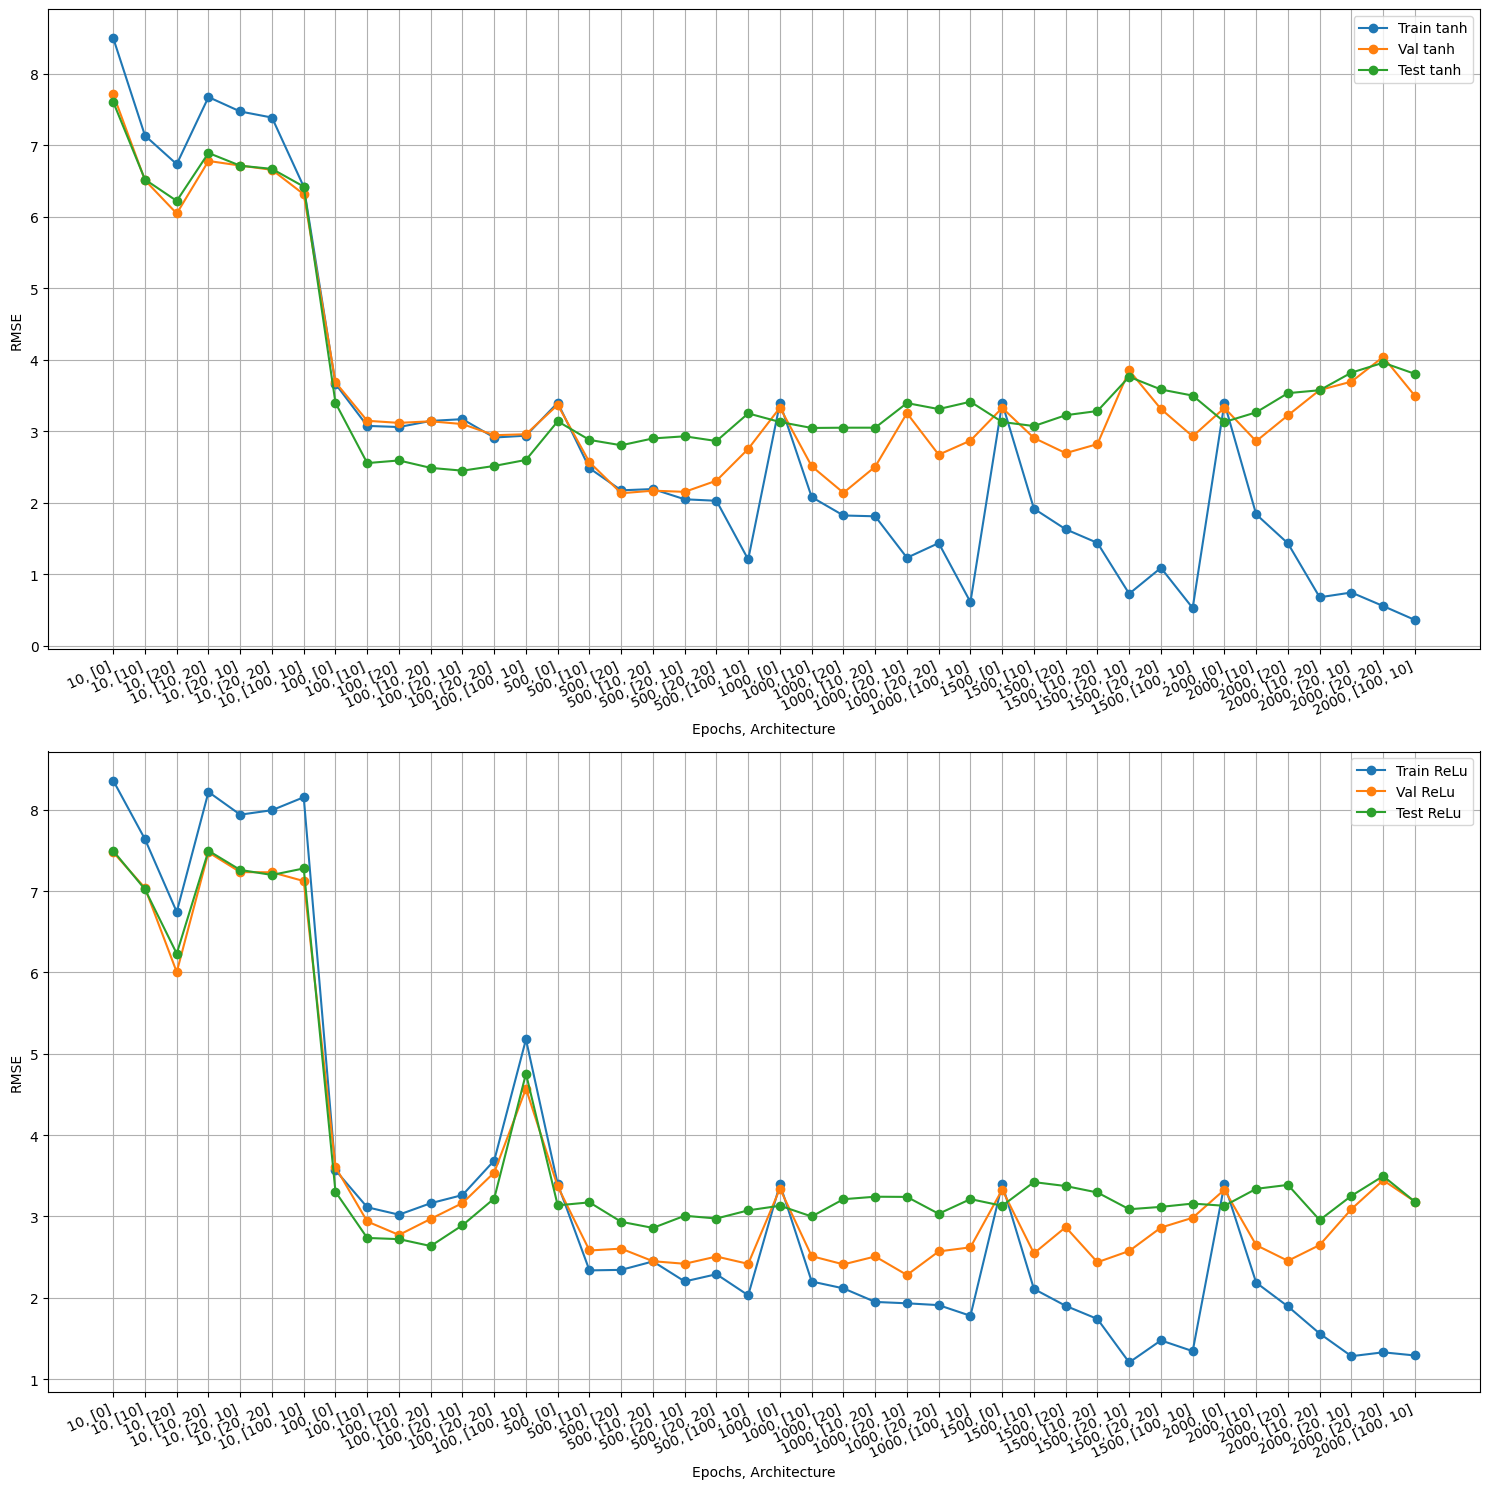

In [26]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)
tanh_df = result_df[(result_df['act func'] == 'tanh')]
xs = range(tanh_df.shape[0])
plt.plot(xs, tanh_df[['RMSE Train', 'RMSE Val', 'RMSE Test']], 'o-')
xticks = tanh_df[['epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) 
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Epochs, Architecture')
plt.ylabel('RMSE')
plt.legend(('Train tanh', 'Val tanh', 'Test tanh'))
plt.grid('on')

plt.subplot(2, 1, 2)
relu_df = result_df[(result_df['act func'] == 'relu')]
xs = range(relu_df.shape[0])
plt.plot(xs, relu_df[['RMSE Train', 'RMSE Val', 'RMSE Test']], 'o-')
xticks = relu_df[['epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) 
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Epochs, Architecture')
plt.ylabel('RMSE')
plt.legend(('Train ReLu', 'Val ReLu', 'Test ReLu'))
plt.grid('on')

plt.tight_layout();

Describe at least three different observations you make about these plots.  What do you find interesting?

1. When comparing the two activation functions, the ReLu function seems to be impacted less by overfitting. I say this because the difference between Test RMSE, when compared to Val RMSE or Train RMSE, is noticeably less for many of the ticks on the x-axis when comparing the ReLu activation function to the tanh activation function. This difference is more noticeable once we reach {500, [100, 10]} on the x-axis and forward. Additionally, the maximum difference between the Test RMSE & Train RMSE is roughly 3 for tanh, then roughly 2 for ReLu, further showing that ReLu is less prone to the overfitting of data.
2. Both activation functions seem to perform similarly on the train, val, and test sets when the `nh` value is [0]. These experiments are some of the few that produce similar RMSE values between the three predictions for both activation functions. I am assuming this is due to the simplicity of this dataset and does not require the level of model complexity that high valued hidden layer units provide. 
3. Evidence of the inconsistency produced by the tanh function can be seen in the plot due to the sporadic jumps of the Train RMSE in the latter half of the graph. When viewing ReLu's Train RMSE, we instead see the values decreasing at a slower, more consistent pace. When viewing ReLu's Train & Test RMSE, we see that the values diverge at a much slower pace, with less sporadic changes as the hyperparameters grow larger.
4. Another interesting observation is that the Train RMSE drops below 1 for the tanh function in the latter half of the plot. This is not the case for the ReLu activation function, which is another indicator of tanh being more prone to overfitting as the Test and Val RMSE values are greater than 2 in these cases.


## Grading and Check-in

You and your partner will score of 70 points if your functions are defined correctly. You can test this grading process yourself by downloading [A2grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A2grader.zip) and extract `A2grader.py` parallel to this notebook.  We recommend keeping this notebook and the grader script in a dedicated folder with *just those two files.* Run the code in the in the following cell to see an example grading run.  If your functions are defined correctly, you should see a score of 70/70.  The remaining 30 points will be based on 1) other testing and the results you obtain, and 2) your discussions.

In [21]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Youngren-A2.ipynb' and storing in notebookcode.py


[NbConvertApp] Converting notebook Youngren-A2.ipynb to script


Removing all statements that are not function or class defs or import statements.

Testing
  w = np.array([0.0])
  def cubic(wmin):
      return (w[0] - wmin) ** 3 + (w[0] - wmin) ** 2
  def grad_cubic(wmin):
      return 3 * (w[0] - wmin) ** 2 + 2 * (w[0] - wmin)
  wmin = 0.5
  opt = Optimizers(w)
  errors_sgd = opt.sgd(cubic, grad_cubic, [wmin], 100, 0.01)

sgd: Epoch 10 Error=0.11889
sgd: Epoch 20 Error=0.11092
sgd: Epoch 30 Error=0.10176
sgd: Epoch 40 Error=0.09162
sgd: Epoch 50 Error=0.08081
sgd: Epoch 60 Error=0.06972
sgd: Epoch 70 Error=0.05879
sgd: Epoch 80 Error=0.04844
sgd: Epoch 90 Error=0.03901
sgd: Epoch 100 Error=0.03072

--- 10/10 points. Returned correct value.

Testing
  w = np.array([0.0])
  def cubic(wmin):
      return (w[0] - wmin) ** 3 + (w[0] - wmin) ** 2
  def grad_cubic(wmin):
      return 3 * (w[0] - wmin) ** 2 + 2 * (w[0] - wmin)
  wmin = 0.5
  opt = Optimizers(w)
  errors_adam = opt.adam(cubic, grad_cubic, [wmin], 100, 0.01)

Adam: Epoch 10 Error=0.09899
Ada

Name this notebook as `Lastname1-Lastname2-A2.ipynb`| with Lastname1 being then name of the last name of the person who is turning in the notebook.

A different but similar grading script will be used to grade your checked-in notebook.  It will include different tests.

## Extra Credit: 5 point

Add the Swish activation function as a third choice in your `train` function in your `NeuralNetwork` class.
A little googling will find definitions of it and its gradient.  Start with [this article](https://www.machinecurve.com/index.php/2019/05/30/why-swish-could-perform-better-than-relu/#todays-activation-functions).

Use your `run_experiment` function to compare results for all three activation functions.  Discuss the results.

In [22]:
swish_df = result_df[result_df['act func'] == 'swish']
swish_df

,epochs,nh,lr,act func,RMSE Train,RMSE Val,RMSE Test
2,10,[0],0.01,swish,6.735357,6.016622,6.215984
5,10,[10],0.01,swish,7.434905,6.616416,6.693297
8,10,[20],0.01,swish,6.359408,5.481869,5.878093
11,10,"[10, 20]",0.01,swish,8.002777,7.197529,7.178400
14,10,"[20, 10]",0.01,swish,8.123743,7.398027,7.266762
17,10,"[20, 20]",0.01,swish,8.098438,7.268690,7.276840
20,10,"[100, 10]",0.01,swish,7.944564,6.903093,7.070089
23,100,[0],0.01,swish,3.532909,3.638389,3.297920
26,100,[10],0.01,swish,3.100799,2.793943,2.818987
29,100,[20],0.01,swish,2.916304,2.657543,2.893184


In [23]:
lowest_sw_val_RMSE = swish_df[swish_df['RMSE Val'] == swish_df['RMSE Val'].min()]
print("Expiriment with lowest validation RMSE for swish:")
lowest_sw_val_RMSE

Expiriment with lowest validation RMSE for swish:


,epochs,nh,lr,act func,RMSE Train,RMSE Val,RMSE Test
53,500,"[10, 20]",0.01,swish,2.487948,2.450057,2.999063


/tmp/ipykernel_58/408545863.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xticks = swish_df[['epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1)
/tmp/ipykernel_58/408545863.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xticks = relu_df[['epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1)
/tmp/ipykernel_58/408545863.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xticks = tanh_df[['epochs', 'nh']].ap

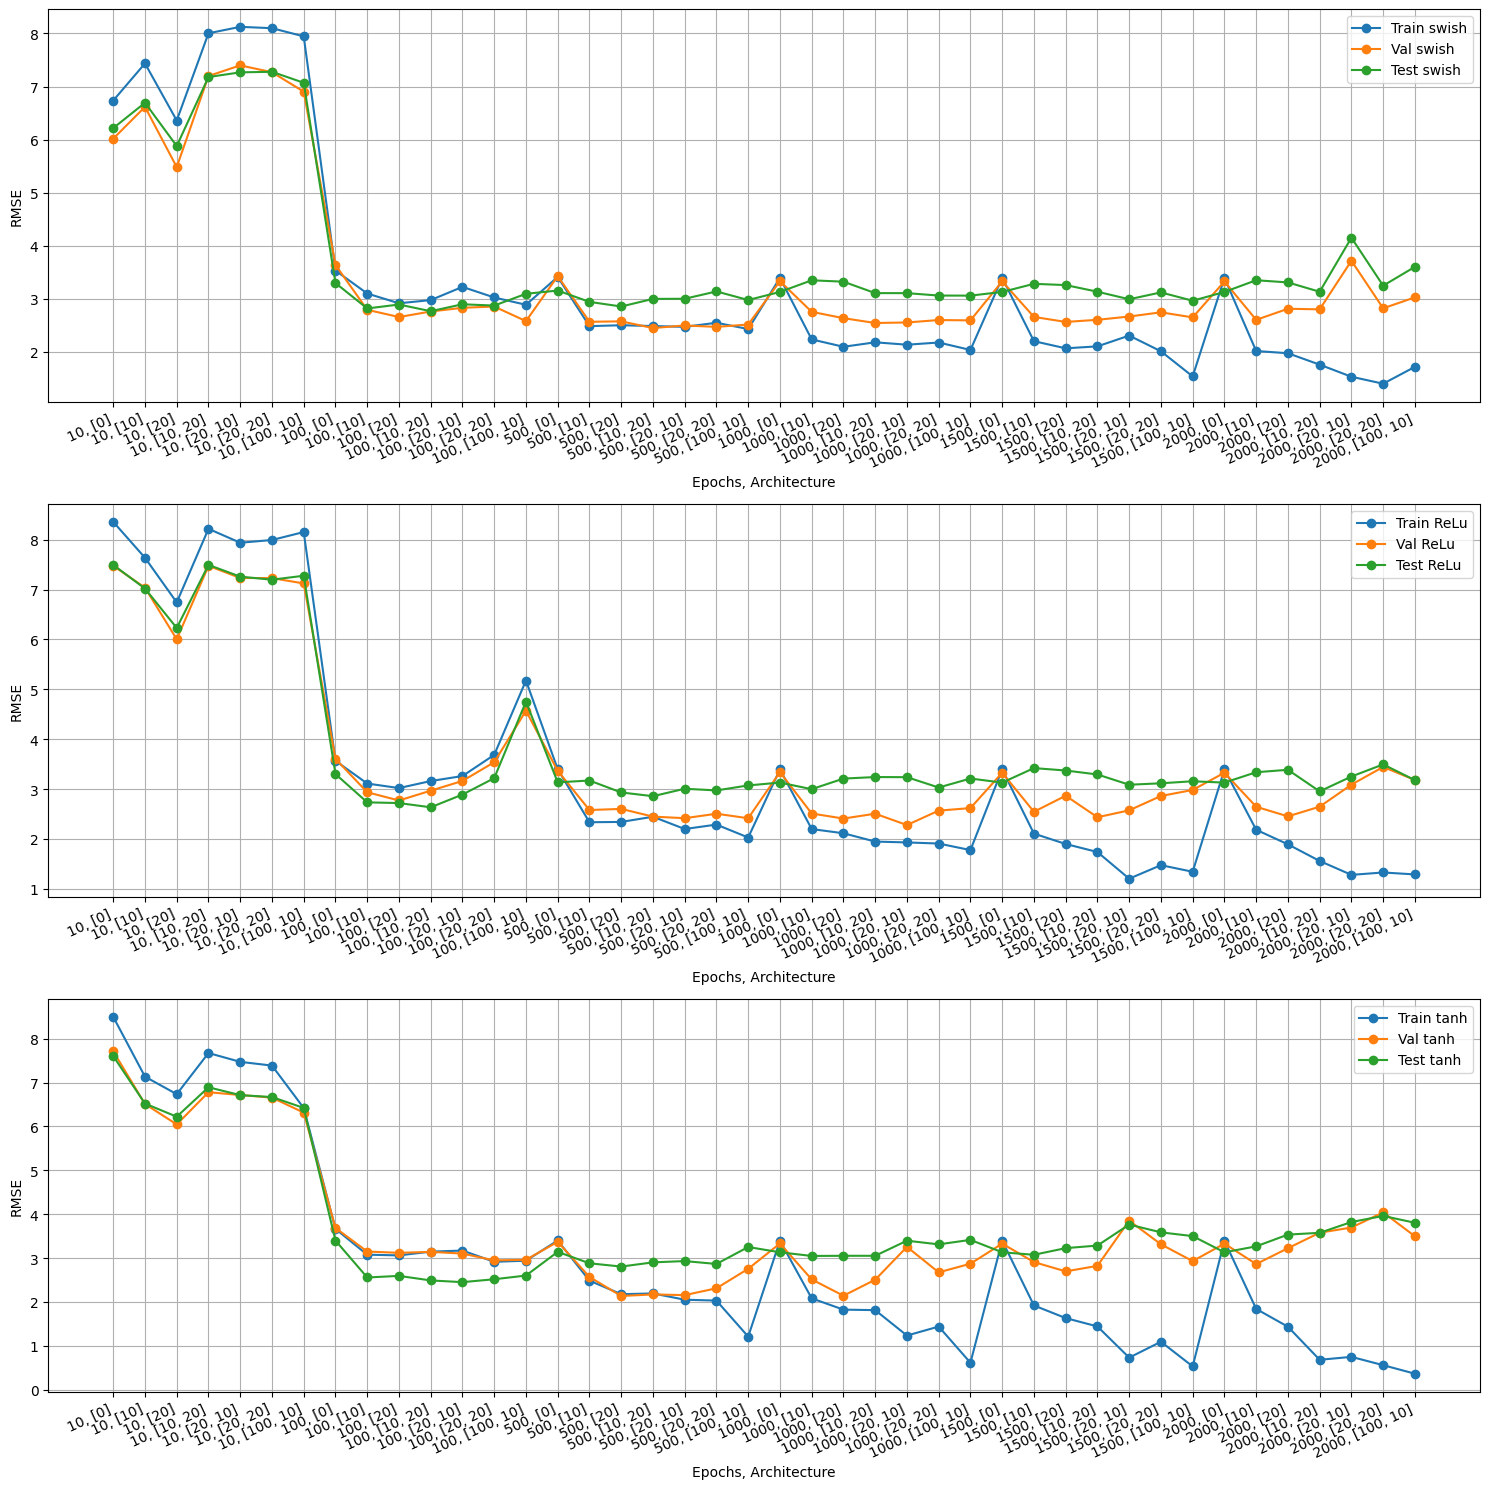

In [27]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
swish_df = result_df[(result_df['act func'] == 'swish')]
xs = range(swish_df.shape[0])
plt.plot(xs, swish_df[['RMSE Train', 'RMSE Val', 'RMSE Test']], 'o-')
xticks = swish_df[['epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) 
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Epochs, Architecture')
plt.ylabel('RMSE')
plt.legend(('Train swish', 'Val swish', 'Test swish'))
plt.grid('on')

plt.subplot(3, 1, 2)
relu_df = result_df[(result_df['act func'] == 'relu')]
xs = range(relu_df.shape[0])
plt.plot(xs, relu_df[['RMSE Train', 'RMSE Val', 'RMSE Test']], 'o-')
xticks = relu_df[['epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) 
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Epochs, Architecture')
plt.ylabel('RMSE')
plt.legend(('Train ReLu', 'Val ReLu', 'Test ReLu'))
plt.grid('on')

plt.subplot(3, 1, 3)
tanh_df = result_df[(result_df['act func'] == 'tanh')]
xs = range(tanh_df.shape[0])
plt.plot(xs, tanh_df[['RMSE Train', 'RMSE Val', 'RMSE Test']], 'o-')
xticks = tanh_df[['epochs', 'nh']].apply(lambda x: f'{x[0]}, {x[1]}', axis=1) 
plt.xticks(range(len(xticks)), xticks, rotation=25, ha='right')
plt.xlabel('Epochs, Architecture')
plt.ylabel('RMSE')
plt.legend(('Train tanh', 'Val tanh', 'Test tanh'))
plt.grid('on')

plt.tight_layout();

### Swish Discussion

Taking my discussion between Relu and tanh from the previous section into account, it seems that the swish function impacts predictions similarly to the ReLu activation function. Although, it does seem slightly less prone to overfitting than ReLu with more complex hidden layer units and a higher number of epochs. For the swish function, there is less of a difference between the Train and Test RMSEs for many of the later ticks on the x-axis, {1000, [10]} to {2000, [100, 10]}. Additionally, we see much less variation in RMSE values for the swish activation function than the ReLu or tanh activation functions for the train, validation, and test sets.